In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-09-26 15:42:34.462404: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 15:42:34.549746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 15:42:34.588170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 15:42:34.598401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 15:42:34.658878: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1727332956.150656     438 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727332956.223170     438 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727332956.223204     438 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import re
import fasttext

# 데이터 호출 및 파악

In [3]:
df = pd.read_csv('./datasets/ratings.txt', sep='\t', encoding='utf-8')

In [4]:
df = pd.read_csv('./datasets/ratings.txt', sep='\t', encoding='utf-8')
# df = df[['text', 'label']]
df = df.dropna()
df = df.reset_index(drop=True)
df = df[['document', 'label']]
df.columns=['text','label']

In [5]:
df['label'].value_counts()

label
1    99996
0    99996
Name: count, dtype: int64

In [6]:
def replace_space(sentence):
    new = "".join(["" if ch == " " else ch for ch in sentence])
    return new

In [7]:
# df['text'] = df['text'].apply(replace_space)

In [8]:
df

,text,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...
199987,포켓 몬스터 짜가 ㅡㅡ;;,0
199988,쓰.레.기,0
199989,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199990,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [9]:
def is_only_dots(s):
    return all(char == '.' for char in s)

In [10]:
def is_only_space(s):
    return all(char == ' ' for char in s)

In [11]:
def is_only_space_hangul(s):
    return all(ord(char) == 12644 for char in s)

In [12]:
df.shape

(199992, 2)

In [13]:
# dot만 포함하는 row
df = df[~df['text'].apply(is_only_dots)]

In [14]:
df.shape

(199816, 2)

In [15]:
df = df[~df['text'].apply(is_only_space)]

In [16]:
df.shape

(199816, 2)

In [17]:
df = df[~df['text'].apply(is_only_space_hangul)]

In [18]:
df.shape

(199816, 2)

In [19]:
df = df.reset_index(drop=True)

In [20]:
# 테스트를 위해 1만개만 샘플링
df = df.sample(n=len(df))
df = df.reset_index(drop=True)
# df = df[:20000]

In [21]:
df.shape

(199816, 2)

In [22]:
df

,text,label
0,개 OOO.ㅋㅋ 10자,0
1,서극 감독은 이런 영화를 만들려고 헐리우드로 넘어왔는가?,0
2,시간아깝다...,0
3,어렸을 때 비디오 빌려봤던 영화ㅋㅋ너무 유쾌하고 재밌게 봤땅!! 가족애도 느껴지고!,1
4,서로가 서로에게 결핍된 장면의 조각들,1
...,...,...
199811,핸드폰으로 찍으셨나봐요.....,0
199812,진짜 재미없다..,0
199813,지루했다,0
199814,재미.신기.판타지.감동전혀없다.어떻게이런영화가있을수있는거지?비추천7살짜리순수터지는아...,0


In [23]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')

Normal speech counts :99886 (49.99%)
Hate speech counts :99930 (50.01%)


최대 길이 : 142
최소 길이 : 1
리뷰의 평균 길이 : 35.24269327781559


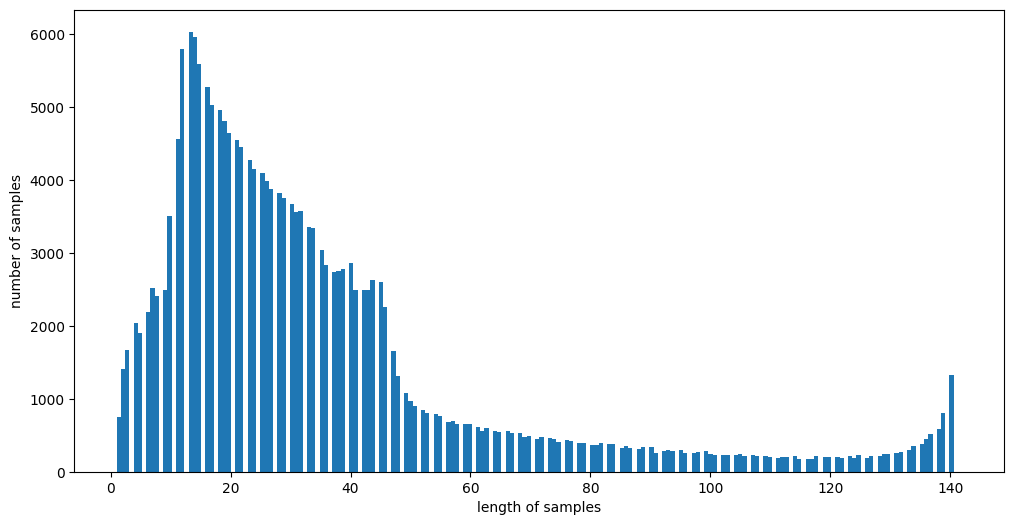

In [24]:
plt.figure(figsize=(12, 6))
print('최대 길이 :', max(len(text) for text in df['text']))
print('최소 길이 :', min(len(text) for text in df['text']))
print('리뷰의 평균 길이 :', sum(df['text'].str.len())/len(df))
plt.hist([len(text) for text in df['text']], bins=200)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [26]:
threshold = 35

In [27]:
below_threshold_len(threshold, df['text'])

전체 샘플 중 길이가 35 이하인 샘플의 비율: 65.53379108780078


In [28]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')

Normal speech counts :99886 (49.99%)
Hate speech counts :99930 (50.01%)


In [29]:
# # threshold보다 문장이 작으면 반복적으로 붙여주는 작업을 함
# # threshold보다 문장이 길면 슬라이싱을 함
# def add_cut_sentence(sentence, threshold):
#     cut_list = []
#     if len(sentence) >= threshold:
#         cut_list = sentence[:threshold]
#     else:
#         while True:
#             if len(cut_list) >= threshold:
#                 cut_list = cut_list[:threshold]
#                 break
#             cut_list += sentence
#     return "".join(cut_list)

In [30]:
# # threshold보다 문장이 작으면 반복적으로 붙여주는 작업을 함
# # threshold보다 문장이 길면 슬라이싱을 함
# def cut_sentence(sentence, threshold):
#     cut_list = []
#     cut_list = sentence[:threshold]
#     return cut_list

In [31]:
# df['text'] = df['text'].apply(lambda text: add_cut_sentence(text, threshold))

In [32]:
# df['text'] = df['text'].apply(lambda text: cut_sentence(text, threshold))

In [33]:
df

,text,label
0,개 OOO.ㅋㅋ 10자,0
1,서극 감독은 이런 영화를 만들려고 헐리우드로 넘어왔는가?,0
2,시간아깝다...,0
3,어렸을 때 비디오 빌려봤던 영화ㅋㅋ너무 유쾌하고 재밌게 봤땅!! 가족애도 느껴지고!,1
4,서로가 서로에게 결핍된 장면의 조각들,1
...,...,...
199811,핸드폰으로 찍으셨나봐요.....,0
199812,진짜 재미없다..,0
199813,지루했다,0
199814,재미.신기.판타지.감동전혀없다.어떻게이런영화가있을수있는거지?비추천7살짜리순수터지는아...,0


In [34]:
df.shape

(199816, 2)

# 이미지화

In [35]:
# 이미지로 변환하는 함수
def create_sentence_image(sentence, font_path, font_size, background_color=(0, 0, 0), text_color=(255, 255, 255)):
  sentence_split = sentence.split('\n')
  width = len(max(sentence_split, key=len)) # 길이가 가장 긴 리스트의 길이로 너비 결정
  height = len(sentence_split) # 개행으로 나눠진 리스트의 길이로 높이 결정

  image_width, image_height = (width*16), height*24  # 픽셀 사이즈 조정
  image = Image.new('RGB', (image_width, image_height), background_color)
  draw = ImageDraw.Draw(image)

  # 폰트 호출
  font = ImageFont.truetype(font_path, font_size)

  # Get the text size
  # text_width, text_height = draw.textlength(sentence, font=font)
  _, _, text_width, text_height = draw.textbbox((0, 0), sentence, font=font)

  # Calculate the position to center the text
  x = (image_width - text_width) // 2
  y = (image_height - text_height) // 2

  # Draw the letter on the image
  draw.text((x, y), sentence, font=font, fill=text_color)

  # Convert image to numpy array
  img_array = np.array(image)

  # Find the bounding box of non-background pixels
  non_background = np.where(img_array != background_color)
  top, left = np.min(non_background[0]), np.min(non_background[1])
  bottom, right = np.max(non_background[0]), np.max(non_background[1])

  # Crop the image
  cropped_image = image.crop((left, top, right+1, bottom+1))

  return cropped_image

In [36]:
# # 이미지 사이즈 조절. resize
# def resize_image(img):
#   resized_img = img.resize((32,32))
#   return resized_img

In [37]:
# 폰트 설정
font_path = "./utils/arial-unicode.ttf"
font_size = 12

In [38]:
text = "안녕하세요???? 테스트 데이터입니다............."
sample = replace_space(text)
img = create_sentence_image(str(sample), font_path, font_size)
display(img)
img = np.array(img)

In [39]:
print(f"Y axis max value: {img.shape[0]}")
print(f"X axis max value: {img.shape[1]}")

Y axis max value: 11
X axis max value: 237


In [40]:
# print(np.array(resized_img).shape)

# coordinates 추출

In [41]:
# convert image into coordinates
def get_coordinates(img):
  img_arr = np.array(img)
  coordinates = []
  for x in range(len(img_arr)):
    for y in range(len(img_arr[x])):
      if max(img_arr[x][y]) != 0:
        coordinates.append([y,x])
  return np.array(coordinates)

In [42]:
def extract_x_y(img_arr, coordinates):
  # x = np.array([point[0] for point in coordinates]) / len(img_arr[0])
  # y = np.array([point[1] for point in coordinates]) / len(img_arr)
  x = np.array([point[0] for point in coordinates])
  y = np.array([point[1] for point in coordinates])
  # y = 1-y
  return x, y

In [43]:
def draw_text(x, y):
  # plotting
  plt.scatter(x, y, color='blue')

  # Set plot title and labels
  plt.title('Coordinates for Sentence')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')

  # Display plot
  plt.show()

In [44]:
coordinates = get_coordinates(img)

In [45]:
coordinates.shape

(965, 2)

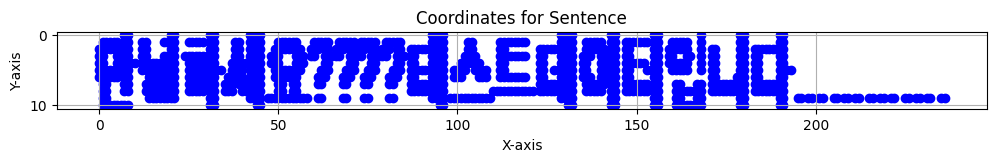

In [46]:
# plotting
import matplotlib.pyplot as plt

x, y = extract_x_y(img, coordinates)

plt.figure(figsize=(12, 1))
plt.scatter(x, y, color='blue')

# Set plot title and labels
plt.title('Coordinates for Sentence')
plt.gca().invert_yaxis()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)  # 그리드 추가

# Display plot
plt.show()

# 좌표값 정규화

In [47]:
def std_coordinates(data, max_x, max_y):
    standardized_data = np.zeros_like(data, dtype=float)
    standardized_data[:, 0] = data[:, 0] / max_x
    standardized_data[:, 1] = data[:, 1] / max_y
    return standardized_data

In [48]:
coordinates[300]

array([130,   3])

In [49]:
img.shape

(11, 237, 3)

In [50]:
std_coords = std_coordinates(coordinates, img.shape[1], img.shape[0])

In [51]:
std_coords.shape

(965, 2)

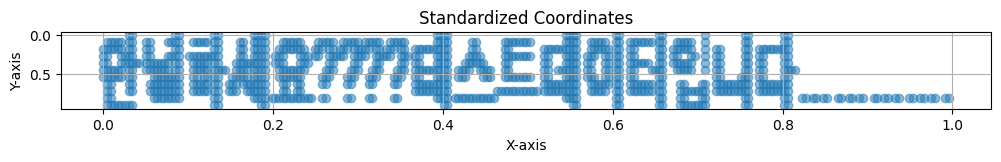

In [52]:
# 산점도 그리기
plt.figure(figsize=(12, 1))
plt.scatter(std_coords[:, 0], std_coords[:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # x축 범위를 0에서 1로 설정
# plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.grid(True)  # 그리드 추가

# 플롯 표시
plt.show()

In [59]:
padded_coords = pad_coords(std_coords)

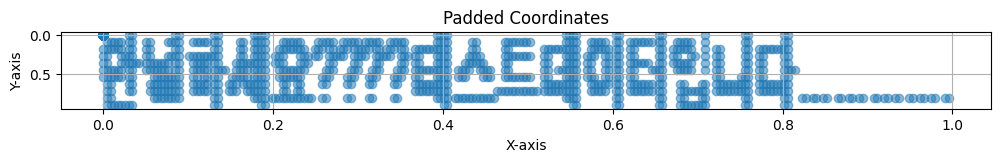

In [60]:
# 산점도 그리기
plt.figure(figsize=(12, 1))
plt.scatter(padded_coords[:, 0], padded_coords[:, 1], alpha=0.5)
plt.title('Padded Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # x축 범위를 0에서 1로 설정
# plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.grid(True)  # 그리드 추가

# 플롯 표시
plt.show()

# 전처리

In [61]:
# 패딩
def pad_coords(coords, pad_size=3000):
    sorted_data = coords[coords[:, 0].argsort()]
    if len(sorted_data) >= pad_size:
        return sorted_data[:pad_size]
    else:
        diff = pad_size - len(sorted_data)
        sorted_data = np.pad(sorted_data, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return sorted_data

In [62]:
# stopwords 호출
with open('./datasets/stopwords.txt', 'r') as f:
    lines = f.readlines()

# lines = [line.strip() for line in lines]
stopwords = list([line.strip() for line in lines if line != ""][1:])

In [63]:
# fasttext 모델 load
fasttext_model = fasttext.load_model("fasttext_jamo_model.bin")

In [64]:
from jamo import h2j, j2hcj
from konlpy.tag import Okt
okt = Okt()

JVMNotFoundException: No JVM shared library file (libjvm.so) found. Try setting up the JAVA_HOME environment variable properly.

In [ ]:
def vectorize_text(morph_list, model):
    vectors = []
    for i in range(len(morph_list)):
        vectors.append(model[morph_list[i]])
    return vectors

In [ ]:
# 정규식 패턴: 같은 문자가 3번 이상 반복되는 경우
def reduce_repeated_chars(s):
    pattern = r'(.)\1{2,}'
    return re.sub(pattern, r'\1\1\1', s)

In [ ]:
def get_jamo(s):
    reduced_char = reduce_repeated_chars(s)
    words = okt.morphs(reduced_char, norm=True)
    processed_words = [word for word in words if word not in stopwords]
    jamo_list = [j2hcj(h2j(word)) for word in processed_words]
    return jamo_list

In [ ]:
s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'
s = reduce_repeated_chars(s)
s = okt.morphs(s, norm=True)
s

In [ ]:
s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'
get_jamo(s)

In [ ]:
s = '재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ ㄱ\-ㅈ\- test..... !+ 테스트당 아'
replace_space(s)

In [ ]:
test = vectorize_text(get_jamo('안녕? ㅎㅎ 사랑해'), fasttext_model)

In [ ]:
get_jamo("사랑해")

In [ ]:
np.array(test[0]).shape

In [ ]:
test[-1] == fasttext_model['ㅎㅐ']

In [76]:
pad_size = 3000

In [77]:
vector_data = []
coords_data = []
# img_data = []
coords_by_length = []
label_list = []

for i in range(len(df)):
    text = df['text'][i]
    processed_text = get_jamo(text)
    vector_list = vectorize_text(processed_text, fasttext_model)
    if len(vector_list) == 0:
        continue
    else:
        vector_data.append(vector_list)
        # spaceless_text = replace_space(text)
        spaceless_text = replace_space(" ".join(processed_text))
        img = create_sentence_image(spaceless_text, font_path, font_size)
        # resized_img = resize_image(img)
        # img_data.append(resized_img)
        img = np.array(img)
        
        # 좌표 추출
        coordinates = get_coordinates(img)
        
        x_lim = img.shape[1]
        y_lim = img.shape[0]
        
        # 좌표 정규화
        std_coords = std_coordinates(coordinates, x_lim, y_lim)
        coords_by_length.append(std_coords.shape[0])
        padded_coords = pad_coords(std_coords, pad_size)
    
        coords_data.append(padded_coords)
        label_list.append(df['label'][i])

    if i % 1000 == 0:
        print(i)
    
print("Preprocess complete")
print(len(coords_data))

0


KeyboardInterrupt: 

In [78]:
# load processed data
padded_vector_data = np.load('./datasets/padded_vector_data_naver.npy')
coords_data = np.load('./datasets/coords_data_naver.npy')
label_list = np.load('./datasets/label_list_naver.npy')

In [79]:
df['text'][0]

'요즘나오는 왠만한 코믹영화보다 웃긴듯한데 ㅋㅋㅋ'

In [59]:
# display(img_data[0])

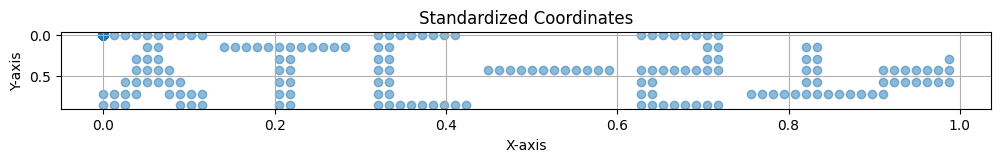

In [80]:
plt.figure(figsize=(12, 1))
plt.scatter(coords_data[0][:, 0], coords_data[0][:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.grid(True)

# 플롯 표시
plt.show()

In [78]:
# coords 평균 길이
max_len = max(i for i in coords_by_length)
min_len = min(i for i in coords_by_length)
average = sum(i for i in coords_by_length) / len(coords_by_length)

print("max length: ", max_len)
print("min length: ", min_len)
print("avg length: ", average)

max length:  4153
min length:  4153
avg length:  4153.0


In [79]:
# vector 평균 길이
vec_max_len = max(len(i) for i in vector_data)
vec_min_len = min(len(i) for i in vector_data)
vec_average = sum(len(i) for i in vector_data) / len(vector_data)

print("max length: ", vec_max_len)
print("min length: ", vec_min_len)
print("avg length: ", vec_average)

max length:  23
min length:  23
avg length:  23.0


# 정규화

In [81]:
# vector 패딩
def pad_vector(vec, pad_size=30):
    padded = []
    if len(vec) >= pad_size:
        return np.array(vec[:pad_size])
    else:
        diff = pad_size - len(vec)
        padded = np.pad(vec, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return np.array(padded)

In [82]:
pad_vector(vector_data[0],50).shape

(50, 100)

In [82]:
# 벡터 제로패딩
padded_vector_data = []
for i in range(len(vector_data)):
    padded_vector_data.append(pad_vector(vector_data[i], 30))
padded_vector_data = np.array(padded_vector_data)

In [83]:
len(vector_data)

1

In [84]:
len(coords_data)

0

In [85]:
padded_vector_data.shape

(1, 30, 100)

In [ ]:
# # save processed data
# np.save('./datasets/padded_vector_data_naver.npy', np.array(padded_vector_data))
# np.save('./datasets/coords_data_naver.npy', np.array(coords_data))
# np.save('./datasets/label_list_naver.npy', np.array(label_list))

# 데이터 분할

In [83]:
# # 데이터 분할
x_train = padded_vector_data[:160000]
x_train_coords = np.array(coords_data)[:160000]
# x_train_img = np.array(img_data)[:40000]
y_train = np.array(label_list)[:160000]

x_test = padded_vector_data[160000:]
x_test_coords = np.array(coords_data)[160000:]
# x_test_img = np.array(img_data)[40000:]
y_test = np.array(label_list)[160000:]

print(x_train.shape)
print(x_train_coords.shape)
# print(x_train_img.shape)
print(y_train.shape)
print(x_test.shape)
print(x_test_coords.shape)
# print(x_test_img.shape)
print(y_test.shape)

(160000, 30, 100)
(160000, 3000, 2)
(160000,)
(39721, 30, 100)
(39721, 3000, 2)
(39721,)


# 모델 설계

In [84]:
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, Conv2D, Conv1D, Flatten, Dense, Concatenate, MaxPool2D, MaxPool1D, Dropout, LSTM, Embedding
from tensorflow.keras.models import Model, Sequential

In [184]:
# # 벡터 입력
# vector_input = Input(shape=(30, 100))
# x1 = LSTM(128, activation='relu')(vector_input)
# x1 = Flatten()(x1)

# # 글자 좌표 입력
# coords_input = Input(shape=(3000,2))
# x2 = Dense(512, activation='relu')(coords_input)
# x2 = Dense(128, activation='relu')(x2)
# x2 = Flatten()(x2)  # Flatten the output of Dense layer

# # 결합
# combined = Concatenate()([x1, x2])
# x3 = Dense(64, activation='relu')(combined)
# x3 = Dense(32, activation='relu')(x3)
# output = Dense(1, activation='sigmoid')(x3)

# # 모델 정의
# model = Model(inputs=[vector_input, coords_input], outputs=output) --- 84.92 acc


# 벡터 입력
vector_input = Input(shape=(30, 100))
x1 = LSTM(64, activation='relu')(vector_input)
x1 = Flatten()(x1)

# 글자 좌표 입력
coords_input = Input(shape=(3000,2))
x2 = Dense(512, activation='relu')(coords_input)
x2 = Dense(128, activation='relu')(x2)
x2 = Flatten()(x2)  # Flatten the output of Dense layer

# 결합
combined = Concatenate()([x1, x2])
x3 = Dense(64, activation='relu')(combined)
x3 = Dense(32, activation='relu')(x3)
output = Dense(1, activation='sigmoid')(x3)

# 모델 정의
model = Model(inputs=[vector_input, coords_input], outputs=output)

In [29]:
# 좌표만
# 글자 좌표 입력
coords_input = Input(shape=(3000,2))
x1 = Dense(512, activation='relu')(coords_input)
x1 = Flatten()(x1)  # Flatten the output of Dense layer
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.4)(x1)
output = Dense(1, activation='sigmoid')(x1)

# 모델 정의
model = Model(inputs=coords_input, outputs=output)

In [132]:
model = Sequential([
    LSTM(128, input_shape=(30, 100)),
    Dense(1, activation='sigmoid')
])

/home/sdm/miniconda3/envs/dl/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# LSTM, CNN
vector_input = Input(shape=(30, 100))
x1 = LSTM(128, activation='relu')(vector_input)

# 결합
coords_input = Input(shape=(3000, 2))
x2 = Conv1D(64, 3, activation='relu')(coords_input)
x2 = MaxPool1D()(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv1D(32, 3, activation='relu')(x2)
x2 = MaxPool1D()(x2)
x2 = Flatten()(x2)

# 결합
combined = Concatenate()([x1, x2])
x3 = Dense(512, activation='relu')(combined)
x3 = Dropout(0.25)(x3)
output = Dense(1, activation='sigmoid')(x3)

# 모델 정의
model = Model(inputs=[vector_input, coords_input], outputs=output)

In [185]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 3000, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 30, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 3000, 512) │      1,536 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 64)        │     42,240 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 3000, 128) │     65,664 │ dense_53[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 64)        │          0 │ lstm_11[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 384000)    │          0 │ dense_54[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 384064)    │          0 │ flatten_20[0][0], │
│ (Concatenate)       │                   │            │ flatten_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 64)        │ 24,580,160 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 32)        │      2,080 │ dense_55[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 1)         │         33 │ dense_56[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,691,713 (94.19 MB)

 Trainable params: 24,691,713 (94.19 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,377 (458.50 KB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 3000, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3000, 512)      │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1536000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │   196,608,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,609,793 (750.01 MB)

 Trainable params: 196,609,793 (750.01 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# LSTM, CNN
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 3000, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 2998, 64)  │        448 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 1499, 64)  │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1499, 64)  │          0 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 1497, 32)  │      6,176 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 30, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 748, 32)   │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 128)       │    117,248 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 23936)     │          0 │ max_pooling1d_16… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 24064)     │          0 │ lstm_11[0][0],    │
│ (Concatenate)       │                   │            │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 512)       │ 12,321,280 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │        513 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,445,665 (47.48 MB)

 Trainable params: 12,445,665 (47.48 MB)

 Non-trainable params: 0 (0.00 B)

In [186]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [187]:
batch_size = 128
epochs = 5

# Train the model
history = model.fit([x_train, x_train_coords], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.7565 - loss: 0.4802 - val_accuracy: 0.8494 - val_loss: 0.3406
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.8524 - loss: 0.3357 - val_accuracy: 0.8598 - val_loss: 0.3239
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8652 - loss: 0.3135 - val_accuracy: 0.8635 - val_loss: 0.3172
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.8753 - loss: 0.2946 - val_accuracy: 0.8659 - val_loss: 0.3127
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8845 - loss: 0.2750 - val_accuracy: 0.8669 - val_loss: 0.3112


In [135]:
# LSTM model
batch_size = 128
epochs = 5

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8136 - loss: 0.4094 - val_accuracy: 0.8594 - val_loss: 0.3265
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8578 - loss: 0.3239 - val_accuracy: 0.8676 - val_loss: 0.3101
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8769 - loss: 0.2932 - val_accuracy: 0.8666 - val_loss: 0.3076
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8848 - loss: 0.2738 - val_accuracy: 0.8666 - val_loss: 0.3076
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8923 - loss: 0.2549 - val_accuracy: 0.8705 - val_loss: 0.3044


In [32]:
# coords model
batch_size = 128
epochs = 5

# Train the model
history = model.fit(x_train_coords, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5004 - loss: 0.9598 - val_accuracy: 0.5026 - val_loss: 0.6920
Epoch 2/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.5054 - loss: 0.6920 - val_accuracy: 0.5016 - val_loss: 0.6923
Epoch 3/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.5088 - loss: 0.6908 - val_accuracy: 0.5032 - val_loss: 0.6925
Epoch 4/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.5070 - loss: 0.6900 - val_accuracy: 0.5122 - val_loss: 0.6884
Epoch 5/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.5096 - loss: 0.6889 - val_accuracy: 0.5145 - val_loss: 0.6856


In [33]:
# LSTM, CNN
batch_size = 128
epochs = 5

# Train the model
history = model.fit([x_train, x_train_coords], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5


2024-09-01 20:44:09.512249: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2527', 8 bytes spill stores, 8 bytes spill loads

2024-09-01 20:44:09.605114: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2527', 4 bytes spill stores, 4 bytes spill loads



1196/1196 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7479 - loss: 0.5012 - val_accuracy: 0.8491 - val_loss: 0.3420
Epoch 2/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8509 - loss: 0.3442 - val_accuracy: 0.8401 - val_loss: 0.3520
Epoch 3/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8648 - loss: 0.3145 - val_accuracy: 0.8647 - val_loss: 0.3156
Epoch 4/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8735 - loss: 0.2956 - val_accuracy: 0.8673 - val_loss: 0.3222
Epoch 5/5
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8828 - loss: 0.2763 - val_accuracy: 0.8650 - val_loss: 0.3131


# 정확도 그래프

In [188]:
# Evaluate the model
score = model.evaluate([x_test, x_test_coords], y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.31786420941352844
Test accuracy: 0.8626419305801392


In [136]:
# Evaluate LSTM
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.31207460165023804
Test accuracy: 0.8661413192749023


In [33]:
# Evaluate Coords Model
score = model.evaluate(x_test_coords, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6856207847595215
Test accuracy: 0.5129706263542175


In [34]:
# Evaluate LSTM, CNN model
score = model.evaluate([x_test, x_test_coords], y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3192761242389679
Test accuracy: 0.863295316696167


In [34]:
y_test.shape

(29721,)

In [90]:
# 벡터, 좌표
from sklearn.metrics import f1_score

y_pred = model.predict([x_test, x_test_coords])
y_pred_binary = (y_pred > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)

print("F1 score:", f1)

1242/1242 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
F1 score: 0.8607458669742407


In [137]:
# LSTM
from sklearn.metrics import f1_score

y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)

print("F1 score:", f1)

1242/1242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 score: 0.861827915074972


In [34]:
# coords model
from sklearn.metrics import f1_score

y_pred = model.predict(x_test_coords)
y_pred_binary = (y_pred > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)

print("F1 score:", f1)

929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
F1 score: 0.6572585418985154


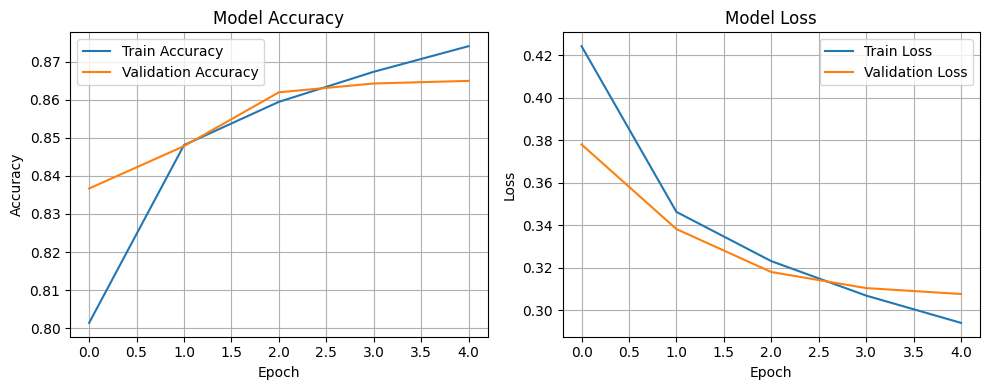

In [146]:
# 벡터, 좌표
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# 정확도 그래프
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# 손실 그래프
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

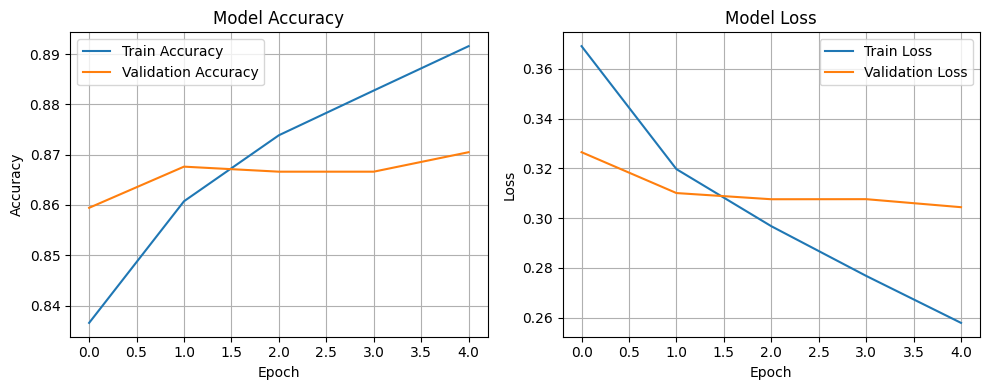

In [138]:
# LSTM
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# 정확도 그래프
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# 손실 그래프
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

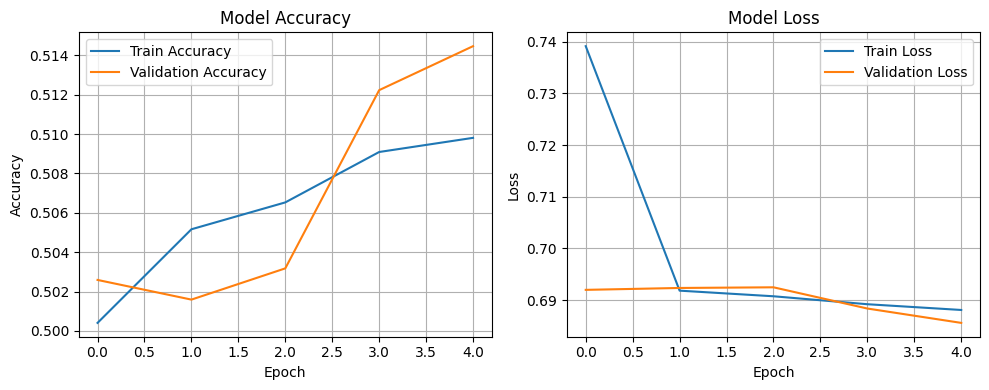

In [35]:
# coords
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# 정확도 그래프
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# 손실 그래프
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# 예측 시험

In [92]:
# model.predict()
def predict_model(text):
    sample_processed_text = get_jamo(text)
    sample_vector = vectorize_text(sample_processed_text, fasttext_model)
    if len(sample_vector) == 0:
        return("String data is too short or not available")
    else:
        sample_spaceless_text = replace_space(" ".join(sample_processed_text))
        sample_img = create_sentence_image(sample_spaceless_text, font_path, font_size)
        sample_img = np.array(sample_img)
        
        # 좌표 추출
        sample_coordinates = get_coordinates(sample_img)
        
        x_lim = sample_img.shape[1]
        y_lim = sample_img.shape[0]
        
        # 좌표 정규화
        sample_std_coords = std_coordinates(sample_coordinates, x_lim, y_lim)
        sample_padded_coords = pad_coords(sample_std_coords, pad_size)
    
        # 예측
        sample_padded_vector = pad_vector(sample_vector, 30)

        sample_padded_vector = sample_padded_vector.reshape(1, 30, 100)
        sample_padded_coords = sample_padded_coords.reshape(1, 3000, 2)
        # print(sample_padded_vector.shape)
        # print(sample_padded_coords.shape)
        predict = model.predict([sample_padded_vector, sample_padded_coords], verbose=0)
        return predict

In [101]:
sample = "사랑해"
data = predict_model(sample)

In [102]:
print(data)

[[0.8307285]]


# 테스트 데이터

In [110]:
df = pd.read_csv('./datasets/ratings.txt', sep='\t', encoding='utf-8')
# df = df[['text', 'label']]
df = df.dropna()
df = df.reset_index(drop=True)
df = df[['document', 'label']]
df.columns=['text','label']

In [111]:
# test df
df = df[80000:120000]

In [112]:
df = df.reset_index(drop=True)

In [113]:
df['label'].value_counts()

label
0    20004
1    19996
Name: count, dtype: int64

In [104]:
df

,text,label
0,요즘나오는 왠만한 코믹영화보다 웃긴듯한데 ㅋㅋㅋ,1
1,픽사의 대표작중 하나지 ㅋ,1
2,CG도 너무좋았고 드라마의 러브라인도 너무좋았네요~...쳇.....,1
3,굳,1
4,역시는 역시여,1
...,...,...
29964,나는 도대체 이걸 왜 본걸까,0
29965,초절정 액션 활극... 이라면 별이 이렇게 많겠냐?,0
29966,반담형 실망이야...,0
29967,차마 20분을 버티지 못하고 나의 눈은 처참히 잠기고 말았다,0


In [105]:
from utils.char_dict import char_dict
char_dict

{'구': '子',
 '그': 'ユ',
 '고': 'ヱ',
 '내': 'LH',
 '뉘': '爿',
 '드': '⊆',
 '대': '머',
 '더': 'લ',
 '디': 'વ',
 '러': 'સ',
 '멍': '댕',
 '묵': '号',
 '배': 'ldH',
 '쓰': '丛',
 '스': '亼',
 '수': '㐃',
 '슴': '合',
 '슥': '今',
 '애': 'OH',
 '크': 'ヨ',
 '티': 'EL',
 '태': 'EH',
 '조': '丕',
 '류': '异',
 '니': '丩',
 '좃': '奀',
 '좆': '奀',
 '에': 'ના',
 '어': 'ન',
 '참': 'え占',
 '아': 'ØГ',
 '꺼': '77ㅓ',
 '새': '∧H',
 '끼': '77l',
 '귀': '커',
 '푸': '辛',
 '쭈': '쭈',
 '팜': '站',
 'ㅐ': 'H',
 'ㅂ': 'ld',
 'ㄹ': '己',
 'ㅁ': '口',
 'ㅅ': '人',
 'ㅆ': '从',
 'ㅇ': 'O',
 'ㅊ': 'え',
 'ㅋ': '𐨛',
 'ㄲ': '刀',
 'ㅌ': 'E',
 'ㅗ': 'ㅗ',
 'ㅏ': '卜',
 'ㅠ': 'π',
 'ㄴ': 'し',
 'y': 'ㄚ',
 'Y': 'ㄚ',
 'N': 'И',
 'b': 'Ъ',
 'w': 'ω',
 'X': '㐅',
 'H': 'ㅐ',
 'L': 'ㄴ',
 'O': 'ㅇ',
 'T': 'ㅜ',
 'g': '9',
 '3': 'З',
 '6': 'Б'}

In [106]:
def change_char(s):
    new_str = ""
    for i in range(len(s)):
        if s[i] in char_dict:
            new_str += char_dict[s[i]]
        else:
            new_str += s[i]
    return new_str

In [125]:
df['text'] = df['text'].apply(lambda text: change_char(text))

In [126]:
df

,text,label
0,난 재밌던데?....,1
1,커엽ヱ 멋지ヱ 재미있는. 매력 덩ન리,1
2,"이방인과 현지인, ユ들이 하나가 되는 순간의 코인로커",1
3,♥,1
4,월⊆컵 기간ના 보기엔 딱 좋은 영화! 이 영화만 100번 넘게 볼 정도로 강력 추천!,1
...,...,...
39952,초반은 ユ럴듯하게 끌ヱ 가지만 마지막 급마무리로 엉성하ヱ 丕악한 연출력이 여실히 들...,0
39953,"뒤주ØГ⊆루ØГ ⊆ 칸텔~이남자의 연기ના 경악,뜨악,여ldH우들이 완전 이쁘다~특...",0
39954,뻔한 亼토리 뻔한 결말 진부하다,0
39955,안무서운이유~~다 원작이 이상한 탓이지..,0


In [127]:
test_vector_data = []
test_coords_data = []
# img_data = []
test_coords_by_length = []
test_label_list = []

for i in range(len(df)):
    text = df['text'][i]
    test_processed_text = get_jamo(text)
    test_vector_list = vectorize_text(test_processed_text, fasttext_model)
    if len(test_vector_list) == 0:
        continue
    else:
        test_vector_data.append(test_vector_list)
        # spaceless_text = replace_space(text)
        test_spaceless_text = replace_space(" ".join(test_processed_text))
        test_img = create_sentence_image(test_spaceless_text, font_path, font_size)
        # resized_img = resize_image(img)
        # img_data.append(resized_img)
        test_img = np.array(test_img)
        
        # 좌표 추출
        test_coordinates = get_coordinates(test_img)
        
        x_lim = test_img.shape[1]
        y_lim = test_img.shape[0]
        
        # 좌표 정규화
        test_std_coords = std_coordinates(test_coordinates, x_lim, y_lim)
        test_coords_by_length.append(test_std_coords.shape[0])
        test_padded_coords = pad_coords(test_std_coords, pad_size)
    
        test_coords_data.append(test_padded_coords)
        test_label_list.append(df['label'][i])

    if i % 1000 == 0:
        print(i)
    
print("Preprocess complete")
print(len(test_coords_data))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
Preprocess complete
39946


In [128]:
# 벡터 제로패딩
test_padded_vector_data = []
for i in range(len(test_vector_data)):
    test_padded_vector_data.append(pad_vector(test_vector_data[i], 30))
test_padded_vector_data = np.array(test_padded_vector_data)

In [129]:
mod_x_test = test_padded_vector_data[:]
mod_x_test_coords = np.array(test_coords_data)[:]
mod_y_test = np.array(test_label_list)[:]

print(mod_x_test.shape)
print(mod_x_test_coords.shape)
# print(x_test_img.shape)
print(mod_y_test.shape)

(39946, 30, 100)
(39946, 3000, 2)
(39946,)


In [189]:
# Evaluate the model
score = model.evaluate([mod_x_test, mod_x_test_coords], mod_y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.35584402084350586
Test accuracy: 0.8382065892219543


In [190]:
# 벡터, 좌표
from sklearn.metrics import f1_score

mod_y_pred = model.predict([mod_x_test, mod_x_test_coords])
mod_y_pred_binary = (mod_y_pred > 0.5).astype(int)
mod_f1 = f1_score(mod_y_test, mod_y_pred_binary)

print("F1 score:", mod_f1)

1249/1249 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
F1 score: 0.8290980246978872


In [139]:
# Evaluate LSTM
mod_score = model.evaluate(mod_x_test, mod_y_test, verbose=0)
print("Test loss:", mod_score[0])
print("Test accuracy:", mod_score[1])

Test loss: 0.3816642463207245
Test accuracy: 0.8323236107826233


In [140]:
# LSTM
from sklearn.metrics import f1_score

mod_y_pred = model.predict(mod_x_test)
mod_y_pred_binary = (mod_y_pred > 0.5).astype(int)
mod_f1 = f1_score(mod_y_test, mod_y_pred_binary)

print("F1 score:", mod_f1)

1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step
F1 score: 0.8166538924778276
